## Vertex AI Embedding Models: Choosing the Ideal Dimension

[Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/overview) embedding models provide you with both [text embedding](https://cloud.google.com/vertex-ai/generative-ai/docs/embeddings/get-text-embeddings) and [multi-modal embedding](https://cloud.google.com/vertex-ai/generative-ai/docs/embeddings/get-multimodal-embeddings) APIs. The text embedding model generates a 768-dimensional vector for any given text, and you have the flexibility to specify a variable dimension. However, how do you pinpoint the optimal dimension size for your specific use case?

In this notebook, we'll explore an approach to selecting the embedding dimension for your particular use case, dataset, etc.

**Process Overview**  
1. Understand your use case & business metric. Gain clarity on the problem you're addressing and the metrics you're aiming to optimize.
2. Check MTEB metric alignment. Determine whether the Massive Text Embedding Benchmark (MTEB) utilizes the same metric for its leaderboard or if you'll need to conduct custom benchmarks.
3. Select models for experimentation. Decide which models you'd like to evaluate.
4. Run benchmarks. Execute benchmarks on an existing dataset or create a custom one.
5. Choose the ideal model & embedding dimension. Make your final selection based on the insights gathered from your benchmarks.

In [ ]:
# install required packages
!pip install mteb google-cloud-aiplatform --upgrade
!pip install mteb--upgrade

In [6]:
import mteb, tqdm, time, torch
from mteb.models.text_formatting_utils import corpus_to_texts

from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel
from typing import List, Optional, Any
import itertools

import numpy as np
from mteb.model_meta import ModelMeta
from functools import partial
import pandas as pd

import vertexai


In [41]:
LOCATION = 'us-east4' 
PROJECT_ID = 'northam-ce-mlai-tpu'

# Initialize Vertex AI SDK
vertexai.init(project=PROJECT_ID, location=LOCATION)

### MTEB: Massive Text Embedding Benchmark[[Paper](https://arxiv.org/pdf/2210.07316), [leaderboard](https://huggingface.co/spaces/mteb/leaderboard)]
MTEB provides to compare embedding models across a number of datasets & tasks.
MTEB leraderboard covers 8 tasks, over 160 datasets,113 languages & 360+ models

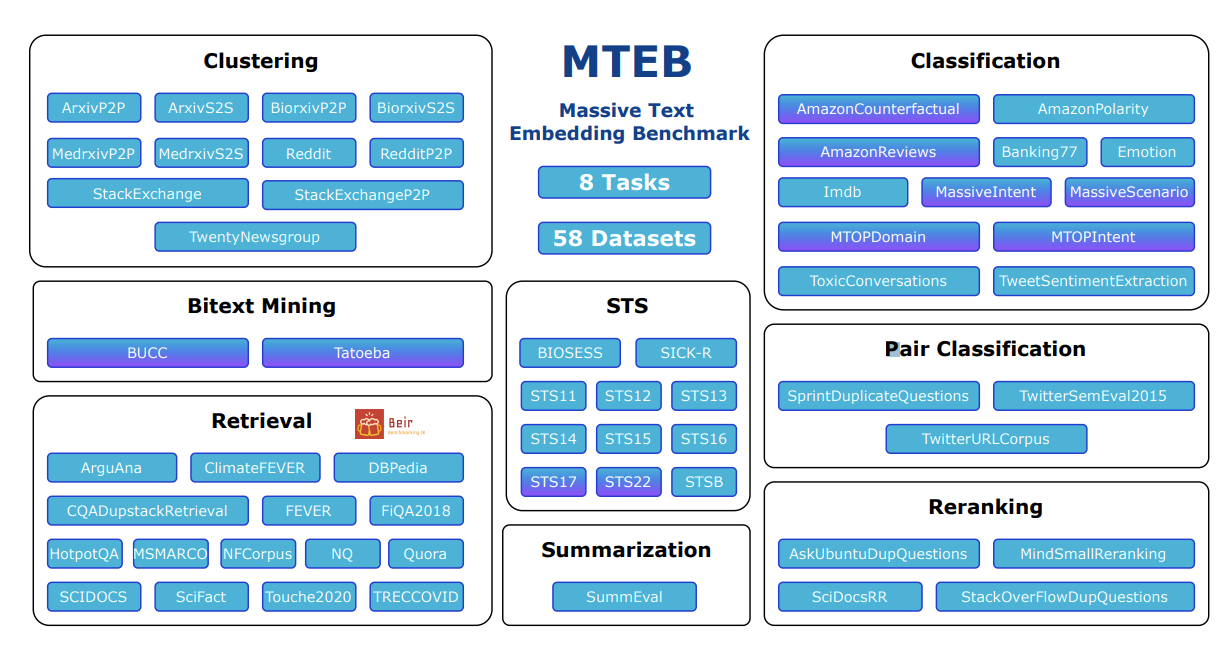

### Run a sample MTEB benchmak on an existing model

In [13]:
from sentence_transformers import SentenceTransformer
# Specify a model name
model_name = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)

# Specify a task or dataset
tasks = [
    mteb.get_task("AmazonReviewsClassification", languages = ["eng"]),
]

evaluation = mteb.MTEB(tasks=tasks)

# run evaluation
results = evaluation.run(model, output_folder=f"results/{model_name}")

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- AmazonReviewsClassification, s2s, multilingual 1 / 6 Subsets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [14]:
results[0].scores

{'validation': [{'accuracy': 0.30302,
   'f1': 0.29983005188434414,
   'f1_weighted': 0.29983005188434414,
   'scores_per_experiment': [{'accuracy': 0.3026,
     'f1': 0.3048554163301936,
     'f1_weighted': 0.3048554163301936},
    {'accuracy': 0.3446,
     'f1': 0.3375582560753593,
     'f1_weighted': 0.33755825607535933},
    {'accuracy': 0.3158,
     'f1': 0.3118627850751892,
     'f1_weighted': 0.3118627850751892},
    {'accuracy': 0.2898,
     'f1': 0.2916711793152056,
     'f1_weighted': 0.2916711793152056},
    {'accuracy': 0.305,
     'f1': 0.29810278978658855,
     'f1_weighted': 0.2981027897865885},
    {'accuracy': 0.3268,
     'f1': 0.32216075320423077,
     'f1_weighted': 0.32216075320423077},
    {'accuracy': 0.27,
     'f1': 0.27031801411699835,
     'f1_weighted': 0.2703180141169983},
    {'accuracy': 0.279,
     'f1': 0.28003789881478086,
     'f1_weighted': 0.28003789881478086},
    {'accuracy': 0.2914,
     'f1': 0.28499255910616766,
     'f1_weighted': 0.2849925591

#### As you can see the results contain various metrics for classification such as acuracy, f1 & f1_weighted and includes it for different dataset splits.

In [15]:
# You can also select dataset using task, categories or languages
tasks = mteb.get_tasks(task_types=["Classification"], languages = ["eng"]) # Only select datasets for classification & in english

# tasks = mteb.get_tasks(categories=["s2s", "p2p"]) # Only select sentence2sentence and paragraph2paragraph datasets

# tasks = mteb.get_tasks(languages=["eng", "deu"]) # Only select datasets which contain "eng" or "deu" (iso 639-3 codes)

In [17]:
len(tasks) 

143

#### There are 143 datasets for Classification in english language. Here are the first 10 of them

In [35]:
tasks[:10]

(AmazonPolarityClassification(name='AmazonPolarityClassification', languages=['eng']),
 ArxivClassification(name='ArxivClassification', languages=['eng']),
 Banking77Classification(name='Banking77Classification', languages=['eng']),
 DBpediaClassification(name='DBpediaClassification', languages=['eng']),
 EmotionClassification(name='EmotionClassification', languages=['eng']),
 FinancialPhrasebankClassification(name='FinancialPhrasebankClassification', languages=['eng']),
 FrenkEnClassification(name='FrenkEnClassification', languages=['eng']),
 ImdbClassification(name='ImdbClassification', languages=['eng']),
 CanadaTaxCourtOutcomesLegalBenchClassification(name='CanadaTaxCourtOutcomesLegalBenchClassification', languages=['eng']),
 ContractNLIConfidentialityOfAgreementLegalBenchClassification(name='ContractNLIConfidentialityOfAgreementLegalBenchClassification', languages=['eng']))

### You can also define your own custom model and run evaluation using that

In [35]:
# lets define a wrapper for VertexAI text embedding model
from mteb.encoder_interface import Encoder
from google.api_core.exceptions import ResourceExhausted
import backoff

class VertexAIWrapper(Encoder):
    def __init__(self, model_name: str, embed_dim: int, **kwargs) -> None:

        from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel

        self._model_name = model_name
        self._embed_dim = embed_dim
    
    @backoff.on_exception(backoff.expo, ResourceExhausted, max_time=10)
    def _embed(
        self, sentences: list[str], *, task_type: str, titles: list[str] | None = None
    ) -> np.ndarray:
        
        print(f"task_type:{task_type}")
        try:
            from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel
            self._model = TextEmbeddingModel.from_pretrained(model_name)
        except ImportError:
            raise ImportError(
                "`google-cloud-aiplatform` is required to run the google API, please install it using `pip install google-cloud-aiplatform`"
            )

        if titles:
            
            inputs = [TextEmbeddingInput(text=sentence, task_type=task_type, title = title) for title, sentence in zip(titles, sentences)]
            kwargs = dict(output_dimensionality=self._embed_dim) if self._embed_dim else {}
            kwargs["auto_truncate"] = True
            print(f"kwargs:{kwargs}")
            BATCH_SIZE = 250
            
            embs = []
            for i in tqdm.tqdm(range(0, len(inputs), BATCH_SIZE)):
                time.sleep(.06)  # to avoid the quota error
                result = self._model.get_embeddings(inputs[i : i + BATCH_SIZE],**kwargs)
                embs = embs + [e.values for e in result]
        
            result = genai.embed_content(  # type: ignore
                model=self.model_name,
                content=sentences,
                task_type=task_type,
                title=titles,
            )
        else:
            inputs = [TextEmbeddingInput(sentence, task_type) for sentence in sentences]
            kwargs = dict(output_dimensionality=self._embed_dim) if self._embed_dim else {}
            kwargs["auto_truncate"] = True
            print(f"kwargs:{kwargs}")
            BATCH_SIZE = 250
            
            embs = []
            for i in tqdm.tqdm(range(0, len(inputs), BATCH_SIZE)):
                time.sleep(.06)  # to avoid the quota error
                result = self._model.get_embeddings(inputs[i : i + BATCH_SIZE],**kwargs)
                embs = embs + [e.values for e in result]

        return self._to_numpy(embs)
        
    def encode(
        self,
        sentences: list[str],
        prompt_name: str | None = None,
        **kwargs: Any,
    ) -> np.ndarray:
        input_type = "RETRIEVAL_DOCUMENT"  # Default
        if prompt_name:
            task = mteb.get_task(prompt_name)
            task_type = task.metadata.type
            if task_type in ["Classification", "MultilabelClassification"]:
                input_type = "CLASSIFICATION"
            elif task_type == "Clustering":
                input_type = "CLUSTERING"
            elif task_type == "STS":
                input_type = "SIMILARITY"
        return self._embed(sentences, task_type=input_type)


    def encode_queries(self, queries: list[str], **kwargs: Any) -> np.ndarray:
        return self._embed(queries, task_type="RETRIEVAL_QUERY")

    def encode_corpus(self, corpus: list[dict[str, str]], **kwargs: Any) -> np.ndarray:
        if isinstance(corpus, dict):
            sentences, titles = [], []

            for i in range(len(corpus["text"])):  # type: ignore
                titles.append(corpus["title"][i])  # type: ignore
                sentences.append(corpus["text"][i])  # type: ignore
        else:
            sentences, titles = [], []
            for doc in corpus:
                titles.append(doc["title"])
                sentences.append(doc["text"])
        return self._embed(sentences, task_type="RETRIEVAL_DOCUMENT")
    
    def _to_numpy(self, embedding_response) -> np.ndarray:
        return np.array([e for e in embedding_response])
    

#### Run a quick sanity check

In [36]:
model_name = "text-embedding-004"
embed_dim = 64
model = VertexAIWrapper(model_name = model_name, embed_dim = embed_dim, name = f"{model_name}-{embed_dim}")

In [37]:
emb_value = model.encode(['I am highly satisfied with my purchase of Expresso Machine'])

task_type:RETRIEVAL_DOCUMENT
kwargs:{'output_dimensionality': 64, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


In [38]:
# Check dimentionality of the vector
len(emb_value[0])

64

### Lets run benchmarks on a classification dataset on different size embedding dimensions generated using text-embedding-004

In [39]:
def run_experiemnt(task: list, model_name: str):
    outputs = {}
    for i in range(64,769, 64):
        print(f"Dim = {i}")
        vertex_text_embedding = VertexAIWrapper(model_name = model_name, embed_dim = i) 
        evaluation = mteb.MTEB(tasks=tasks)
        results = evaluation.run(vertex_text_embedding, output_folder=f"results/{model_name}/{i}")
        outputs[i] = results  
    return outputs

In [42]:
tasks = [
    mteb.get_task("AmazonReviewsClassification", languages = ["eng"]),
]
model_name = "text-embedding-004"
outputs = run_experiemnt(tasks, model_name)

Dim = 64


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- AmazonReviewsClassification, s2s, multilingual 1 / 6 Subsets

task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 64, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 64, 'auto_truncate': True}


100%|██████████| 20/20 [00:37<00:00,  1.85s/it]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLE

task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 64, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 64, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 64, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 64, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 64, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 64, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 64, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 64, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 64, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 64, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 64, 'auto_truncate': True}


100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 64, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 64, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 64, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 64, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 64, 'auto_truncate': True}


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 64, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 64, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 64, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 64, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Dim = 128


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- AmazonReviewsClassification, s2s, multilingual 1 / 6 Subsets

task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 128, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 128, 'auto_truncate': True}


100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 128, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 128, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 128, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 128, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 128, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 128, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 128, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 128, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 128, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 128, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 128, 'auto_truncate': True}


100%|██████████| 20/20 [00:38<00:00,  1.94s/it]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 128, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 128, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 128, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 128, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 128, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 128, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 128, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 128, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 128, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Dim = 192


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- AmazonReviewsClassification, s2s, multilingual 1 / 6 Subsets

task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 192, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 192, 'auto_truncate': True}


100%|██████████| 20/20 [00:40<00:00,  2.02s/it]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 192, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 192, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 192, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 192, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 192, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 192, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 192, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 192, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 192, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 192, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 192, 'auto_truncate': True}


100%|██████████| 20/20 [00:39<00:00,  1.99s/it]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 192, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 192, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 192, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 192, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 192, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 192, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 192, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 192, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 192, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Dim = 256


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- AmazonReviewsClassification, s2s, multilingual 1 / 6 Subsets

task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 256, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 256, 'auto_truncate': True}


100%|██████████| 20/20 [00:40<00:00,  2.05s/it]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 256, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 256, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 256, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 256, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 256, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 256, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 256, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 256, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 256, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 256, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 256, 'auto_truncate': True}


100%|██████████| 20/20 [00:41<00:00,  2.06s/it]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 256, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 256, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 256, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 256, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 256, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 256, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 256, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 256, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 256, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Dim = 320


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- AmazonReviewsClassification, s2s, multilingual 1 / 6 Subsets

task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 320, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 320, 'auto_truncate': True}


100%|██████████| 20/20 [00:42<00:00,  2.13s/it]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 320, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 320, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 320, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 320, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 320, 'auto_truncate': True}


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 320, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 320, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 320, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 320, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 320, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 320, 'auto_truncate': True}


100%|██████████| 20/20 [00:40<00:00,  2.02s/it]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 320, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 320, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 320, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 320, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 320, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 320, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 320, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 320, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 320, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Dim = 384


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- AmazonReviewsClassification, s2s, multilingual 1 / 6 Subsets

task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 384, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 384, 'auto_truncate': True}


100%|██████████| 20/20 [00:45<00:00,  2.28s/it]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 384, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 384, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 384, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 384, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 384, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 384, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 384, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 384, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 384, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 384, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 384, 'auto_truncate': True}


100%|██████████| 20/20 [00:43<00:00,  2.18s/it]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 384, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 384, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 384, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 384, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 384, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 384, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 384, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 384, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 384, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Dim = 448


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- AmazonReviewsClassification, s2s, multilingual 1 / 6 Subsets

task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 448, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 448, 'auto_truncate': True}


100%|██████████| 20/20 [00:45<00:00,  2.28s/it]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 448, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 448, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 448, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 448, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 448, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 448, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 448, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 448, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 448, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 448, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 448, 'auto_truncate': True}


100%|██████████| 20/20 [00:44<00:00,  2.22s/it]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 448, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 448, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 448, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 448, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 448, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 448, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 448, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 448, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 448, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Dim = 512


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- AmazonReviewsClassification, s2s, multilingual 1 / 6 Subsets

task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 512, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 512, 'auto_truncate': True}


100%|██████████| 20/20 [00:45<00:00,  2.28s/it]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 512, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 512, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 512, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 512, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 512, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 512, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 512, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 512, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 512, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 512, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 512, 'auto_truncate': True}


100%|██████████| 20/20 [00:47<00:00,  2.37s/it]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 512, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 512, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 512, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 512, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 512, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 512, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 512, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 512, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 512, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Dim = 576


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- AmazonReviewsClassification, s2s, multilingual 1 / 6 Subsets

task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 576, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 576, 'auto_truncate': True}


100%|██████████| 20/20 [00:48<00:00,  2.41s/it]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 576, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 576, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 576, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 576, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 576, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 576, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 576, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 576, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 576, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 576, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 576, 'auto_truncate': True}


100%|██████████| 20/20 [00:47<00:00,  2.40s/it]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 576, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 576, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 576, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 576, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 576, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 576, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 576, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 576, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 576, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Dim = 640


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- AmazonReviewsClassification, s2s, multilingual 1 / 6 Subsets

task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 640, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 640, 'auto_truncate': True}


100%|██████████| 20/20 [00:48<00:00,  2.44s/it]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 640, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 640, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 640, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 640, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 640, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 640, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 640, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 640, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 640, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 640, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 640, 'auto_truncate': True}


100%|██████████| 20/20 [00:48<00:00,  2.41s/it]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 640, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 640, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 640, 'auto_truncate': True}


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 640, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 640, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 640, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 640, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 640, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 640, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Dim = 704


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- AmazonReviewsClassification, s2s, multilingual 1 / 6 Subsets

task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 704, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 704, 'auto_truncate': True}


100%|██████████| 20/20 [00:49<00:00,  2.48s/it]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 704, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 704, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 704, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 704, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 704, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 704, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 704, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 704, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 704, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 704, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 704, 'auto_truncate': True}


100%|██████████| 20/20 [00:48<00:00,  2.45s/it]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 704, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 704, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 704, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 704, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 704, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 704, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 704, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 704, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 704, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Dim = 768


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- AmazonReviewsClassification, s2s, multilingual 1 / 6 Subsets

task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 768, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 768, 'auto_truncate': True}


100%|██████████| 20/20 [00:49<00:00,  2.49s/it]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 768, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 768, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 768, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 768, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 768, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 768, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 768, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 768, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 768, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 768, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 768, 'auto_truncate': True}


100%|██████████| 20/20 [00:50<00:00,  2.53s/it]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 768, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 768, 'auto_truncate': True}


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 768, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 768, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 768, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 768, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 768, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 768, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


task_type:CLASSIFICATION
kwargs:{'output_dimensionality': 768, 'auto_truncate': True}


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


In [43]:
outputs[64][0].scores

{'validation': [{'accuracy': 0.43704,
   'f1': 0.33637191150135354,
   'f1_weighted': 0.33637191150135354,
   'scores_per_experiment': [{'accuracy': 0.4268,
     'f1': 0.3035642266766219,
     'f1_weighted': 0.3035642266766219},
    {'accuracy': 0.4318,
     'f1': 0.3073512715498416,
     'f1_weighted': 0.3073512715498416},
    {'accuracy': 0.4556,
     'f1': 0.39104721368012685,
     'f1_weighted': 0.3910472136801269},
    {'accuracy': 0.4328,
     'f1': 0.3544857192121069,
     'f1_weighted': 0.354485719212107},
    {'accuracy': 0.4322,
     'f1': 0.33500084371633404,
     'f1_weighted': 0.33500084371633404},
    {'accuracy': 0.454,
     'f1': 0.3751788329175419,
     'f1_weighted': 0.3751788329175419},
    {'accuracy': 0.4352,
     'f1': 0.33911783633481846,
     'f1_weighted': 0.33911783633481846},
    {'accuracy': 0.4378,
     'f1': 0.32743367637126947,
     'f1_weighted': 0.32743367637126947},
    {'accuracy': 0.4506,
     'f1': 0.35296744419944376,
     'f1_weighted': 0.35296744

In [44]:
def plot_mteb_benchmark_data(outputs, metrics: str, title: str, split: str = 'validation'):
    dims = list(outputs.keys())
    dims.sort()
    f1 = []
    f1_weighted = []
    accuracy = []
    data = {}
    for dim in dims:
        for metric in metrics:
            if metric not in data:
                data[metric] = [] 

            data[metric].append(outputs[dim][0].scores[split][0][metric])
                            
    import matplotlib.pyplot as plt
    import numpy as np
    
    print(data)

    # Create a DataFrame from the data
    df = pd.DataFrame({'dims': dims})
    # df = pd.DataFrame({'dims': dims, 'f1': f1, 'f1_weighted': f1_weighted, 'accuracy': accuracy})
    
    for metric in metrics:
        df.insert(1, metric, data[metric], True)

    # Observe the result
    # print(df)

    # Create the plot
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    markers = ['s', 'o', 'x']
    linestyles = ['-','--', '-.']
    
    for i, metric in enumerate(metrics):
        plt.plot(df['dims'], df[metric], marker=markers[i % len(markers)], 
                 linestyle=linestyles[i % len(linestyles)], label=metric)
        
    # Add labels and title
    plt.xlabel('Dimension')
    plt.ylabel('Score')
    plt.title(title)
    plt.xticks(df['dims'])  # Ensure all dimensions are shown on the x-axis
    plt.legend()

    # Show the plot
    plt.grid(axis='y', alpha=0.75)  # Add a subtle grid for readability
    plt.show()

{'f1': [0.33637191150135354, 0.33708862464401557, 0.3654322599370282, 0.3777611128020343, 0.38787179607258143, 0.39927922022705364, 0.4073386654327811, 0.4154751413082448, 0.4196387804637518, 0.4248491204202935, 0.43016922938778046, 0.4345358459762177], 'accuracy': [0.43704, 0.43907999999999997, 0.4542, 0.46044, 0.46588, 0.47216, 0.4769400000000001, 0.48172, 0.48326, 0.48612, 0.48906, 0.49169999999999997], 'f1_weighted': [0.33637191150135354, 0.33708862464401557, 0.36543225993702816, 0.3777611128020343, 0.38787179607258143, 0.3992792202270536, 0.4073386654327811, 0.4154751413082448, 0.4196387804637518, 0.4248491204202935, 0.4301692293877803, 0.4345358459762177]}


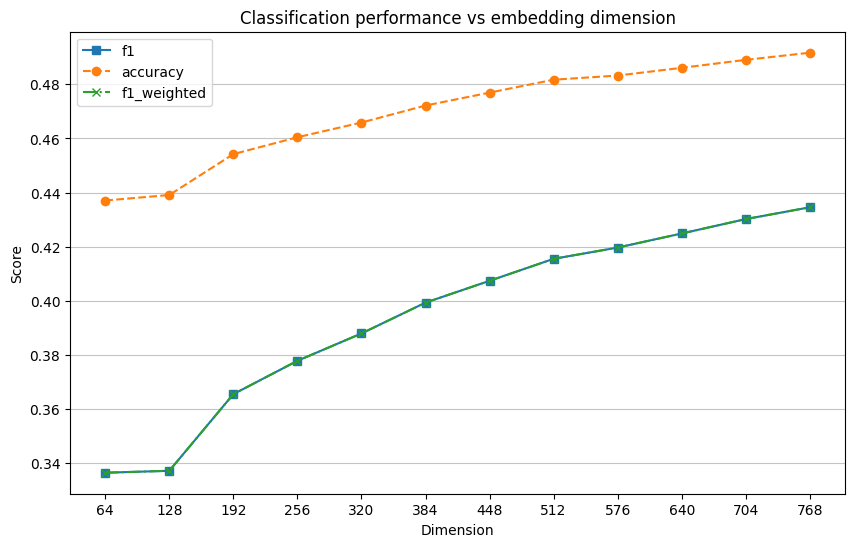

In [45]:
metrics = ["f1","accuracy","f1_weighted"]
title = "Classification performance vs embedding dimension"
plot_mteb_benchmark_data(outputs, metrics= metrics, title = title, split = 'validation')

### Lets run benchmarks on a Retrieval dataset on different size embedding dimensions generated using text-embedding-004

In [ ]:
# specify dataset
tasks = [
    mteb.get_task("ARCChallenge", languages = ["eng"]),
]
model_name = "text-embedding-004"
outputs = run_experiemnt(tasks, model_name)

In [14]:
outputs[192][0].scores

{'test': [{'ndcg_at_1': 0.09471,
   'ndcg_at_3': 0.15655,
   'ndcg_at_5': 0.18141,
   'ndcg_at_10': 0.20257,
   'ndcg_at_20': 0.22427,
   'ndcg_at_100': 0.26588,
   'ndcg_at_1000': 0.30055,
   'map_at_1': 0.09471,
   'map_at_3': 0.14135,
   'map_at_5': 0.1553,
   'map_at_10': 0.16382,
   'map_at_20': 0.16973,
   'map_at_100': 0.17517,
   'map_at_1000': 0.17642,
   'recall_at_1': 0.09471,
   'recall_at_3': 0.20051,
   'recall_at_5': 0.26024,
   'recall_at_10': 0.32679,
   'recall_at_20': 0.41297,
   'recall_at_100': 0.64164,
   'recall_at_1000': 0.91809,
   'precision_at_1': 0.09471,
   'precision_at_3': 0.06684,
   'precision_at_5': 0.05205,
   'precision_at_10': 0.03268,
   'precision_at_20': 0.02065,
   'precision_at_100': 0.00642,
   'precision_at_1000': 0.00092,
   'mrr_at_1': 0.0947098976109215,
   'mrr_at_3': 0.14135381114903303,
   'mrr_at_5': 0.15530432309442552,
   'mrr_at_10': 0.16382150983260196,
   'mrr_at_20': 0.16972966986122245,
   'mrr_at_100': 0.1751688177254033,
   'm

#### ARCChallenge is a dataset under retrieval task so it has retrieval specific metrics such as ndcg_at_10, mrr_at_5

{'ndcg_at_10': [0.12163, 0.18083, 0.20257, 0.21906, 0.22381, 0.23314, 0.23315, 0.24189, 0.24558, 0.2453, 0.25015, 0.25148], 'recall_at_10': [0.2099, 0.28413, 0.32679, 0.34727, 0.35666, 0.37543, 0.37116, 0.38652, 0.3942, 0.39846, 0.407, 0.40956], 'mrr_at_5': [0.08724402730375426, 0.14089874857792936, 0.15530432309442552, 0.16922639362912406, 0.17116040955631398, 0.17746018202502847, 0.17937997724687144, 0.18560864618885098, 0.18714448236632542, 0.18395904436860078, 0.186589874857793, 0.18841012514220706]}


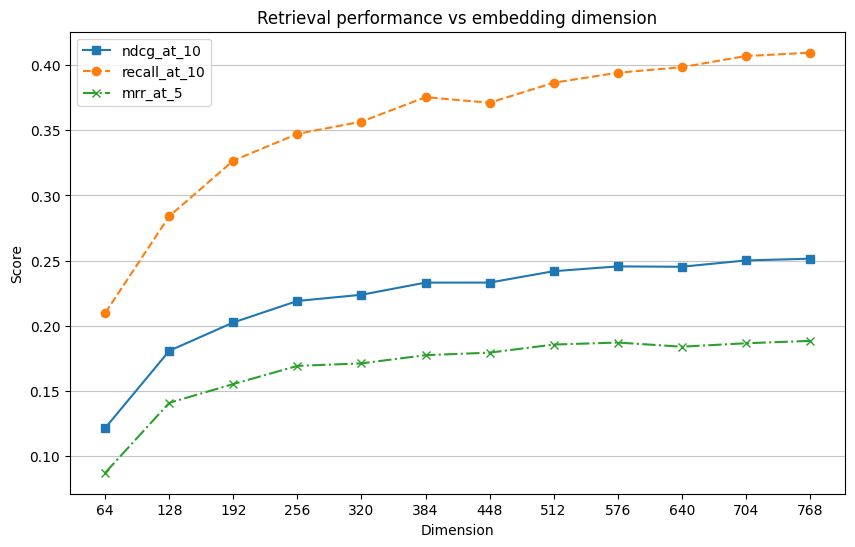

In [17]:
# choose the metrics important to you
metrics = ["ndcg_at_10","recall_at_10","mrr_at_5"]
title = "Retrieval performance vs embedding dimension"
plot_mteb_benchmark_data(outputs, metrics= metrics, title = title, split = 'test')

#### Based on the provided graph and metrics, you can determine the ideal embedding dimension.

### MTEB allows you to use your own dataset for evaluation.  
Refer [here](https://github.com/embeddings-benchmark/mteb/blob/main/docs/adding_a_dataset.md) for details.